In [1]:
'''
Jupyter Notebook by Matthew Loukine
'''
'''
This first block of code is used for import statements, data loading and doing some data pre processing
Such as Motion Correction.
'''
# The following file is being used to test the Pipeline
''' Import statements for all the files involved'''
from main import *
from utils import *
from wfield_utils import *
from registration import *
from hemocorrection import *
from denoising import *
from debug_visualize import *
from data_loading_functions import *
from data_preprocessor import *

# Some extra imports we need
from tqdm import tqdm
import pickle
import scipy.io
import matplotlib.pyplot as plt
import matplotlib as mpl
from datetime import timedelta
import scipy.signal
import cv2
import os

# The folllowing code is from main(). 
# params are global variables used to modify the code
params = {
    'path_to_session_data':       r"C:\Users\evilm\Downloads\12-08-2024",
    'pipe_num':           0,              # select desired pipeline number
    'get_raw_brightness': False,
    'get_DeltaF':         False,
    'get_zScore':         False
          }
STIM_COMPUTER = True # There is STIM COMPUTER Data
BLUE_AND_VIOLET_EXISTS = True # Both types of frames were recorded

# This is inside def main()
# For purposes of testing to visualise the data we will do analysis here.
session_file_paths = get_file_paths(params['path_to_session_data'])
# create an obj for each recording within the session
recording = rawDataPreprocessor(params['path_to_session_data'], blue_and_violet_exists=BLUE_AND_VIOLET_EXISTS,stim_computer=STIM_COMPUTER)
print(f'{datetime.datetime.now().time()}: Done loading session data into object')

# Currently Motion Correction Only
print(f'{datetime.datetime.now().time()}: Starting Motion Correction')
_, _, recording.all_frames = motion_correct(dat=recording.all_frames, out=None, mode='ecc', apply_shifts=True)
print(f'{datetime.datetime.now().time()}: Done Motion Correction')

# Denoising and Compression Step
print(f'{datetime.datetime.now().time()}: Starting Blue Frame Denoising and Compression')
recording.all_frames[:,0,...], _ = denoise_svd(recording.all_frames[:,0,...],rank=200) # Blue Frames are First
print(f'{datetime.datetime.now().time()}: DOne Blue Frame Denoising and Compression')
if BLUE_AND_VIOLET_EXISTS:
    print(f'{datetime.datetime.now().time()}: Starting Blue Frame Denoising and Compression')
    recording.all_frames[:,1,...],  _ = denoise_svd(recording.all_frames[:,1,...] ,rank=200) # Violet Frames are Second
    print(f'{datetime.datetime.now().time()}: Done Blue Frame Denoising and Compression')

# HemoCorrection Step
if BLUE_AND_VIOLET_EXISTS:
    print(f'{datetime.datetime.now().time()}: Starting HemoCorrection')
    recording.all_frames[:,0,...] = hemocorrection(blue_frames=recording.all_frames[:,0,...], violet_frames=recording.all_frames[:,1,...])
    print(f'{datetime.datetime.now().time()}: Done HemoCorrection')

# Segementation Step

# Loading all the other files.
blue_frames = recording.all_frames[:,0,...]
if BLUE_AND_VIOLET_EXISTS:
    violet_frames = recording.all_frames[:,1,...]
analog_data = load_dat_analog(recording.path_to_analog)
frame_times = load_mat_frameTimes(recording.path_to_frameTimes)
blue_ftimes = frame_times['frameTimes']
if BLUE_AND_VIOLET_EXISTS:
    blue_ftimes = frame_times['frameTimes'][::2] # blue frame occurs first
    violet_ftimes = frame_times['frameTimes'][1::2]
    violet_frames = recording.all_frames[:,1,...]
stim_matfile = recording.path_to_stimcomputer
stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
# Skipping software environement
stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())
stim_sync = scipy.io.loadmat(stim_matfile)['sync']

16:11:57.944368: Done loading session data into object
16:11:57.944368: Starting Motion Correction


Motion correction: 100%|██████████| 5/5 [01:29<00:00, 17.90s/it]

16:13:31.299533: Done Motion Correction
16:13:31.300535: Starting Blue Frame Denoising and Compression



Denoising: 100%|██████████| 2575/2575 [07:40<00:00,  5.59it/s]
c:\Users\evilm\OneDrive\Desktop\Lab Work\Trenholm Lab\wfield_pipeline\denoising.py:44: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return (np.array(im_array),np.array(SVD_stack))


16:21:13.165569: DOne Blue Frame Denoising and Compression
16:21:13.165569: Starting Blue Frame Denoising and Compression


Denoising: 100%|██████████| 2575/2575 [07:58<00:00,  5.38it/s]


16:29:14.684111: DOne Blue Frame Denoising and Compression
16:29:14.697079: Starting HemoCorrection


100%|██████████| 2575/2575 [00:26<00:00, 95.57it/s] 


16:31:59.462674: Done HemoCorrection


C:\Users\evilm\AppData\Local\Temp\ipykernel_30916\2932408750.py:79: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_configs = pickle.loads(scipy.io.loadmat(stim_matfile)['configs'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_30916\2932408750.py:80: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_experiment_start_timestamp = pickle.loads(scipy.io.loadmat(stim_matfile)['experiment_start_timestamp'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_30916\2932408750.py:82: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_stim_frame_info = pickle.loads(scipy.io.loadmat(stim_matfile)['stimulus_frame_info'].tostring())
C:\Users\evilm\AppData\Local\Temp\ipykernel_30916\2932408750.py:83: DeprecationWarning: tostring() is deprecated. Use tobytes() instead.
  stim_user_data = pickle.loads(scipy.io.loadmat(stim_matfile)['user_data'].tostring())


In [18]:
blue_ftimes = frame_times['frameTimes'][::2] # blue frame occurs first
violet_ftimes = frame_times['frameTimes'][1::2]

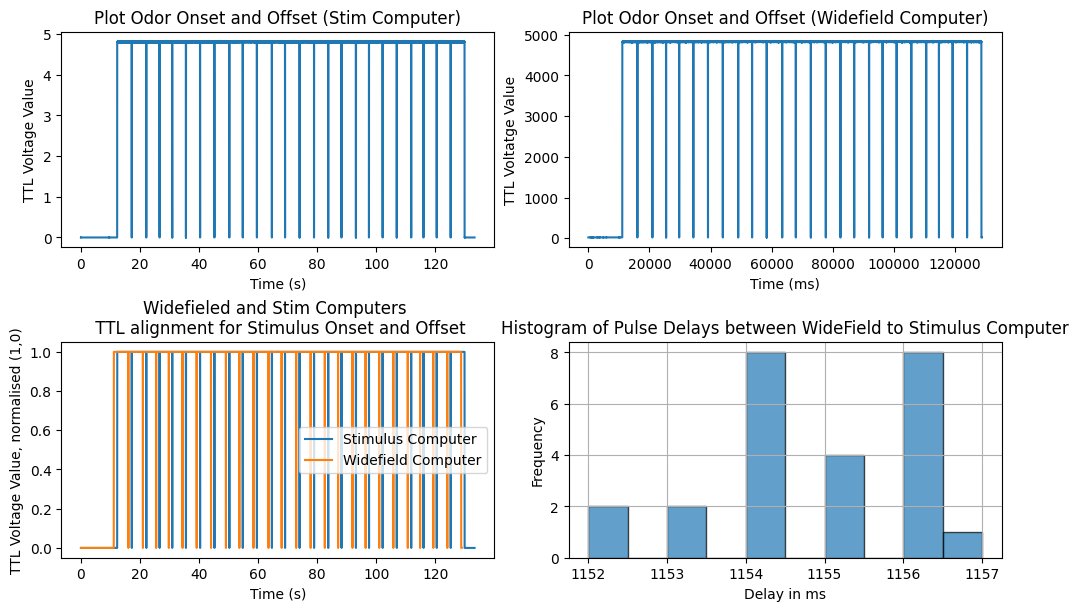

In [16]:
'''
This compares stimulus computer and widefield computer TTL pulses.
This block of code is used for sanity checks!
'''
#matplotlib inline
# This line increases the limit of how many points can be plotted on matplotlib
mpl.rcParams['agg.path.chunksize'] = 100000

def compress_array(arr, factor):
    """
    list<int>, int -> list<int>

    Compress a binary array by a given factor.
    """
    compressed_length = len(arr) // factor
    compressed_array = np.zeros(compressed_length, dtype=int)
    
    for i in range(compressed_length):
        start_idx = i * factor
        end_idx = start_idx + factor
        # Check if there is at least one `1` in the chunk
        if np.any(arr[start_idx:end_idx]):
            compressed_array[i] = 1
    
    return compressed_array.tolist()

# Converting the time into seconds, by deafult it is nano, since sampling rate is 10kHz
x_values = np.arange(1, stim_sync.shape[0] + 1) / 10000

# Making figure with axes
fig,axes = plt.subplots(ncols=2,nrows=2, figsize=(10,6),layout='constrained')

# Plot, remembering stim_sync[1] is the onset of smell. 
# NOTICE the x-axis, we will correct for this further along. 
axes[0,0].plot(x_values, stim_sync[:, 1])
axes[0,0].set_xlabel('Time (s)')
axes[0,0].set_ylabel('TTL Voltage Value')
axes[0,0].set_title('Plot Odor Onset and Offset (Stim Computer)')

wf_analog_data = np.array(analog_data[0])
axes[0,1].plot(wf_analog_data[4])
axes[0,1].set_xlabel('Time (ms)')
axes[0,1].set_ylabel('TTL Voltatge Value')
axes[0,1].set_title('Plot Odor Onset and Offset (Widefield Computer)')

# Normalising pulses, to being between 1 and 0 and turning into binary arrays 
normalised_stim_signal = (stim_sync[:,1]-np.min(stim_sync[:,1]))/(np.max(stim_sync[:,1])-np.min(stim_sync[:,1]))
normalised_stim_signal = np.where(np.array(normalised_stim_signal) > 0.5, 1, 0)
# Stimulus Computer records data 10* the speed of WideField Computer, for comparision and so that we can do alignment later,
# We need to compress the Stimulus Computer Signal by a factor of 10  
normalised_stim_signal = np.array(compress_array(normalised_stim_signal,10))  
# Normalising pulses, to being between 1 and 0 and turning into binary arrays
normalised_wf_signal = (wf_analog_data[4]-np.min(wf_analog_data[4]))/(np.max(wf_analog_data[4])-np.min(wf_analog_data[4])) 
normalised_wf_signal = np.where(np.array(normalised_wf_signal) > 0.5, 1, 0)

# Making x-values for graphing
x_values = np.arange(1, normalised_stim_signal.shape[0] + 1) /  1000 # This converts it into seconds
x_values_two = np.arange(1, wf_analog_data.shape[1] + 1) / 1000 # This convers it into seconds the /1000

axes[1,0].plot(x_values,normalised_stim_signal, label="Stimulus Computer")
axes[1,0].plot(x_values_two,normalised_wf_signal, label="Widefield Computer")
axes[1,0].set_xlabel('Time (s)')
axes[1,0].set_ylabel('TTL Voltage Value, normalised (1,0)')
axes[1,0].set_title('Widefieled and Stim Computers \n TTL alignment for Stimulus Onset and Offset')
axes[1,0].legend()

def find_onset_indices(arr):
    """Find the indices of the first occurrence of `1` in each contiguous block of `1`s in the array."""
    onset_indices = []
    in_pulse = False
    for i, value in enumerate(arr):
        if value > 0.9:
            if not in_pulse:
                onset_indices.append(i)
                in_pulse = True
        else:
            in_pulse = False
    return onset_indices
def calculate_delays(array1, array2):
    """Calculate the delays between the onsets of pulses in two binary arrays."""
    onset_indices1 = find_onset_indices(array1)
    onset_indices2 = find_onset_indices(array2)
    # Ensure both arrays have at least one onset
    if not onset_indices1 or not onset_indices2:
        raise ValueError("One or both arrays do not contain any pulses.")
    delays = []
    len1 = len(onset_indices1)
    len2 = len(onset_indices2)
    max_len = min(len1, len2)
    for i in range(max_len):
        delay = onset_indices1[i] - onset_indices2[i]
        delays.append(delay)
    return delays

delays = calculate_delays(normalised_stim_signal,normalised_wf_signal)
bins = 10
# Compute histogram
counts, edges = np.histogram(delays, bins=bins)
# Use plt.bar to plot histogram with no space between bars
bar_width = edges[1] - edges[0]
axes[1,1].bar(edges[:-1], counts, width=bar_width, edgecolor='black', align='edge', alpha=0.7)
axes[1,1].set_title('Histogram of Pulse Delays between WideField to Stimulus Computer')
axes[1,1].set_xlabel('Delay in ms')
axes[1,1].set_ylabel('Frequency')
axes[1,1].grid(True)

plt.show()

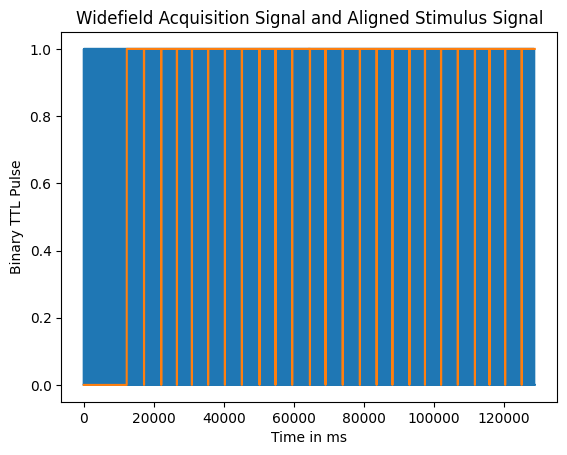

In [12]:
''' 
The following block of code, shows the acquisition and stimulus signal overlapped. 
'''
#The delay is minimal, so we actually can just use the Stimulus Computer TTL, as our WideField one. All we need to do is change the shape.
# If we don't have the Stimulus Computer Data then we use the normalise_wf_signal as out aligned_stim_signal
aligned_stim_signal = normalised_stim_signal[:normalised_wf_signal.shape[0]]

# Now we can line up our acquisition signal and our stim signal
wf_acquisition_signal = np.array(wf_analog_data[1])
# Normalising and turining into binary 
wf_acquisition_signal = (wf_acquisition_signal-np.min(wf_acquisition_signal))/(np.max(wf_acquisition_signal)-np.min(wf_acquisition_signal))
wf_acquisition_signal = np.where(np.array(wf_acquisition_signal) > 0.5 ,1, 0 )

plt.plot(wf_acquisition_signal, label="Widfield Acquisition Signal")
plt.plot(aligned_stim_signal, label='Aligned Stimulus Signal')
plt.ylabel("Binary TTL Pulse")
plt.xlabel('Time in ms')
plt.title('Widefield Acquisition Signal and Aligned Stimulus Signal')
plt.show()
# NOTE - Zooming into the graph, and into one pulse, the acquisition become much clearer.

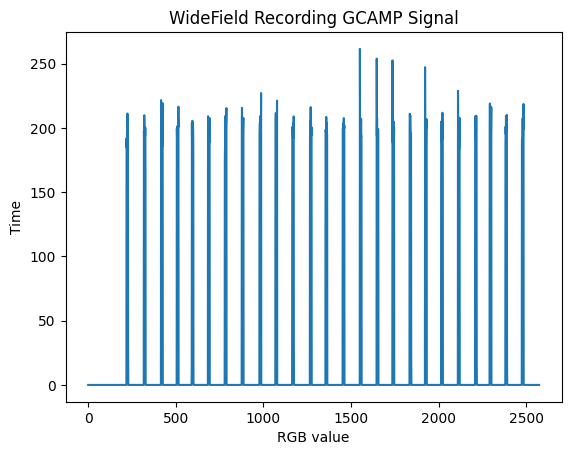

In [34]:
'''
The following before we do any other analysis just plots the signal (the average of the image)
'''
# Calculating a signal over the images
signal_mean = np.mean(blue_frames,axis=(1,2))
plt.plot(signal_mean)
plt.title('WideField Recording GCAMP Signal')
plt.xlabel('RGB value')
plt.ylabel('Time')
plt.show()

# Also calculating how many peaks there are in this signal
# Ideally this should equal the amount of stimulus repeats 
# May need to modify the distance metric. 
peaks, _ = scipy.signal.find_peaks(signal_mean,distance=10)


In [ ]:
def count_blocks_of_ones(binary_array):
    arr = np.array(binary_array)
    transitions = np.diff(arr.astype(int))
    num_blocks = np.sum(transitions == 1) + (arr[0] == 1)
    return num_blocks

In [4]:
# '''
# We have to solve the following problem, the widefield computer saves aquisition time in matlab's datetime.datenum function. Which uses
# Gregorian time. However our olfactory stimulus computer saves olfactometer onset as Unix time. Since the above diagrams have shown 
# that the onset of the olfactometer stimulus release is the same as the widefield computer's record of it. We will use the olfactometer
# stimulus frame info which has unix time of onset of stimulus and offset of stimulus. This is how we align and get only frames within the
# window of stimulus on. 
# '''
# # First is a converstion from a matlab datetime to a python datetime in seconds
# unix_blueftimes = [datetime.datetime.fromordinal(int(float(f_time)))+timedelta(days=float(f_time)%1)-timedelta(days=366) for (f_time) in blue_ftimes]
# # Next is a conversion from python datetime into python unix time, with microsecond precision
# unix_blueftimes = [(time.mktime(f_time.timetuple())*1e3 + f_time.microsecond/1e3)/1e3 for f_time in unix_blueftimes]

# # Getting out the start times
# olfactometer_stimulus_block_times = [float(stim_stim['time']) for stim_stim in stim_stim_frame_info]

# plt.figure()
# # The following plot will show the onset and offset of stimulus in green
# for i,x_coord in enumerate(olfactometer_stimulus_block_times[0::2]):
#     if i == 0:
#         plt.axvline(x_coord,color='green',label='Stimulus Onset')
#     else:
#         plt.axvline(x_coord,color='green',label='_nolegend_')
# # The following plot will show the onset and offset of stimulus in green
# for i,x_coord in enumerate(olfactometer_stimulus_block_times[1::2]):
#     if i == 0:
#         plt.axvline(x_coord,color='red',label='Stimulus Offset')
#     else:
#         plt.axvline(x_coord,color='red',label='_nolegend_')
# # Start of olfactometer experiment in black
# plt.axvline(stim_experiment_start_timestamp,color='black',label='Start of Experiment')

# # Time of frames in blue
# plt.plot(unix_blueftimes,np.arange(1,len(unix_blueftimes)+1),label='Frame Acquisition')
# plt.xlabel('Time (s)')
# plt.ylabel('Frame Number')
# # Put a legend below current axis
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),
#           fancybox=True, shadow=True)
# plt.title("Acquisition over Time")
# plt.show()

In [ ]:
# '''
# Now we have a graph that shows a timed alignment between frame times and is stimulus onset and offset.
# We can now do some analysis by seperating baseline images from stimulus images. 
# '''
# # Turning the olfactometer_stimulus_block_times into a list of tuples, to make the following steps easier
# olfactometer_stimulus_block_times = [(olfactometer_stimulus_block_times[i], olfactometer_stimulus_block_times[i + 1]) for i in range(0, len(olfactometer_stimulus_block_times), 2)]
# olfactometer_stimulus_block_times = np.array(olfactometer_stimulus_block_times)

# # The functon check if a given time falls within any of the specified ranges. 
# def is_within_ranges(time,ranges):
#     return any(start <= time <= end for start,end in ranges)

# # Using list comprehension we generate a binary array of 1,0s. 
# # Where 1 means that the frame is within a stimulus time, and a 0 means the frame is outside
# # of a stimulus time. 
# binary_stim_times = [1 if is_within_ranges(time, olfactometer_stimulus_block_times) else 0 for time in unix_blueftimes]
# binary_stim_times = np.array(binary_stim_times)

# stimulus_frames = []
# baseline_frames = []

# # Dividing frames into stim and baseline
# for i,frame in enumerate(tqdm(blue_frames)):
#     if binary_stim_times[i] == 0:
#         baseline_frames.append(frame[:])
#     else:
#         stimulus_frames.append(frame[:])
# stimulus_frames = np.array(stimulus_frames)
# baseline_frames = np.array(baseline_frames)

# # Generating F
# baseline_avg = np.mean(baseline_frames,axis=0)
# # Generating delta F over F
# # deltaF over F = F(time) - F(baseline) / F(baseline)
# for i, frame in enumerate(tqdm(stimulus_frames)):
#     stimulus_frames[i] = (frame - baseline_avg) / frame

In [10]:
# The following takes the blue frames saves them into jpgs and then converts them to video
for i,frame in enumerate(tqdm(blue_frames)):
    plt.imsave(params["path_to_session_data"] + r"\Data\Frame" + str(i) + ".jpg", frame, cmap='gray')
    
def convert_img_to_video():
    image_folder = r"C:\Users\evilm\Downloads\12-08-2024\Data"
    video_name = r"C:\Users\evilm\Downloads\12-08-2024\Data\video_modified.avi"

    images = [img for img in os.listdir(image_folder) if img.endswith(".jpg")]
    frame = cv2.imread(os.path.join(image_folder, images[0]))
    height, width, layers = frame.shape

    video = cv2.VideoWriter(video_name, 0, 7, (width,height))

    for i,image in enumerate(tqdm(images)):
        video.write(cv2.imread(os.path.join(image_folder, image)))

    cv2.destroyAllWindows()
    video.release()
convert_img_to_video()

100%|██████████| 2575/2575 [00:10<00:00, 240.00it/s]
